# DeepShadows: Separating LSB galaxies from Artifacts using Deep Learning
Version: Luis A. Gutiérrez Soto

Based on [DeepShadows](https://github.com/dtanoglidis/DeepShadows/blob/main/DeepShadows.ipynb).

In [1]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
from scipy import interpolate
import random

In [2]:
# =========================================
# =========================================
# scikit-learn for Machine Learn

# Preprocessing
from sklearn.preprocessing import StandardScaler #Standar scaler for standardization
from sklearn.manifold import TSNE # Dimensionality reduction technique
from sklearn.model_selection import GridSearchCV #Cross-Validation
from sklearn.utils import resample #Resampling
# Classifiers
from sklearn.svm import SVC #Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier as RF #Random Forests
# Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# =======================================
# =======================================
# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# ==============================================
# ==============================================
# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=False)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

2025-05-29 16:39:34.217203: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-29 16:39:34.425446: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748547574.519959    4570 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748547574.541908    4570 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-29 16:39:34.778699: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Verificar si TensorFlow puede acceder a la GPU
print("GPUs disponibles:", tf.config.experimental.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]



Import datasets

    X_tr, X_val, X_test: Refer to the training, validation and test sets for the image-based classification (deep learning).

    y_tr, y_val, y_test: Labels - training, validation and test sets.



In [4]:
# For image-based classification
X_tr = np.float64(np.load("../Datasets_DeepShadows/array_images/X_train.npy")) #Training
X_val = np.float64(np.load("../Datasets_DeepShadows/array_images/X_val.npy")) #Validation
X_test = np.float64(np.load("../Datasets_DeepShadows/array_images/X_test.npy")) #Test


# Labels
y_tr = np.float64(np.load("../Datasets_DeepShadows/Galaxies_data/y_train.npy")) # Training
y_val = np.float64(np.load("../Datasets_DeepShadows/Galaxies_data/y_val.npy")) #Validation
y_test = np.float64(np.load("../Datasets_DeepShadows/Galaxies_data/y_test.npy")) #Test
     


### Plot examples of LSBGs and Artifacts

Now let's make a plot of a random sample of 20 LSBGs and 20 artefacts from the training set.


In [5]:
# Check the sizes of X_tr and y_tr
print("X_training:", len(X_tr), "y_train:",len(y_tr))
print("X_validation:", len(X_val), "y_validation:",len(y_val))
print("X_test:", len(X_test), "y_test:",len(y_test))

X_training: 29580 y_train: 29580
X_validation: 4990 y_validation: 4990
X_test: 4983 y_test: 4983


In [6]:
# Ensure the sizes match by truncating the larger dataset
min_length = min(len(X_tr), len(y_tr))
X_tr = X_tr[:min_length]
y_tr = y_tr[:min_length]

In [7]:
X_pos = X_tr[y_tr==1.] #Positives - LSBGs
X_neg = X_tr[y_tr==0.] #Negatives - Artifacts
# Get some random indices
randind = np.random.randint(0,15000,20)
print(randind)
randind  = [9221,10239,1601,1590,9178,1388,4419,3591,11241,12395,3422,441,
            11547,7808,11841,12008,5189,1081,6403,6299]

X_sample_LSBG = X_pos[randind]
X_sample_Artefacts = X_neg[randind]

[ 9994 11034 10825 14522  7109 11525   271 11481 14165  6336  9932  2545
  7402  4678  7330 11303  7413  9459  2034    84]


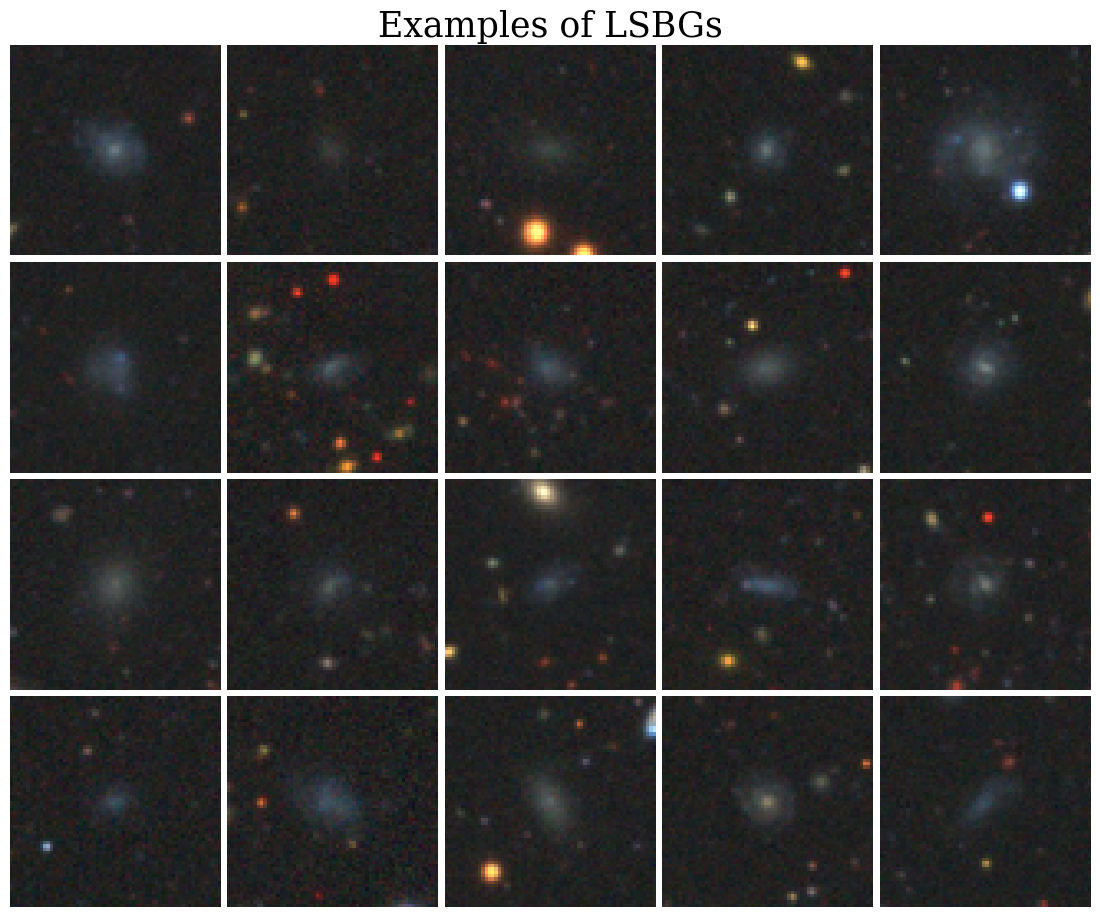

In [13]:
# Plot them
n_rows = 4
n_cols = 5

plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of LSBGs",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_sample_LSBG[i])
    plt.axis('off')


plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("../Plots/LSBG_Examples.jpg")
#files.download("/content/drive/My Drive/Plots/LSBG_Examples.pdf")
plt.show()

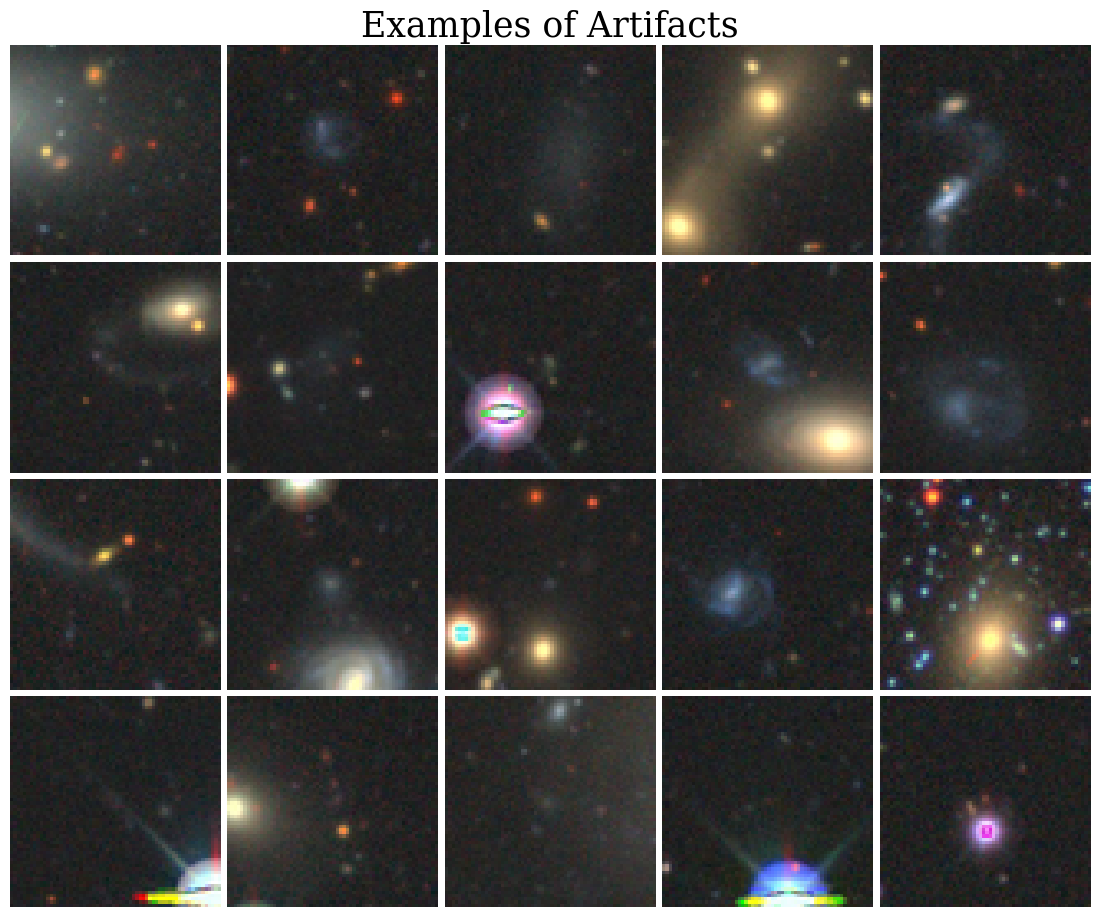

In [14]:
plt.figure(figsize=(4*n_cols*0.7, 4*n_rows*0.7))

for i in range(n_rows*n_cols):
    if (i==3):
        plt.title("Examples of Artifacts",fontsize=25)
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(X_sample_Artefacts[i])
    plt.axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.03)
#plt.tight_layout()
plt.savefig("../Plots/Artifacts_Examples.jpg")
#files.download("/content/drive/My Drive/Plots/Artifacts_Examples.pdf")
plt.show()